# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.

### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?
### Note: don't use the entire dataset, use a sample instead, with n=100000 elements, so your computer doesn't freeze.

In [1]:
# Your code here
# libraries
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
# display for notebooks
%matplotlib inline

In [3]:
%%time
fraud = pd.read_csv("PS_20174392719_1491204439457_log.csv").sample(100000)

CPU times: user 9.94 s, sys: 722 ms, total: 10.7 s
Wall time: 10.9 s


In [4]:
# checking size of df
fraud.shape

(100000, 11)

In [5]:
# checking head and tail
fraud.head()
fraud.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
4534121,326,TRANSFER,596321.71,C571655898,5037.0,0.00,C2145542283,1280745.66,1877067.37,0,0
549344,21,CASH_IN,17975.81,C378407368,964.0,18939.81,C391683289,4229953.59,4319477.72,0,0
4623492,329,TRANSFER,182593.29,C626953582,0.0,0.00,C1164664372,1262092.04,1444685.33,0,0
3212675,249,PAYMENT,999.49,C1702163873,82079.0,81079.51,M2023198334,0.00,0.00,0,0
5246711,371,CASH_OUT,699364.93,C249418747,0.0,0.00,C1045972602,1122916.26,1822281.19,0,0


In [6]:
# checking types
fraud.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [7]:
# checking the amount of unique values in the columns w/dtype object
len(fraud["type"].unique()) # only 5
fraud["type"].unique()

array(['CASH_IN', 'PAYMENT', 'CASH_OUT', 'TRANSFER', 'DEBIT'],
      dtype=object)

In [8]:
len(fraud["nameOrig"].unique()) # from 6 353 307 to 100 000

100000

In [9]:
len(fraud["nameDest"].unique()) # from 2 722 362 to 92 803

92803

In [10]:
# checking descriptive statistics
round(fraud.describe(), 2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,100000.00,100000.00,100000.00,100000.00,1.000000e+05,1.000000e+05,100000.00,100000.0
mean,242.52,180367.60,829521.58,850774.04,1.105908e+06,1.230395e+06,0.00,0.0
std,142.00,636198.70,2886822.00,2922434.23,3.384305e+06,3.703605e+06,0.04,0.0
min,1.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
25%,155.00,13404.68,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
50%,237.00,76184.28,14129.50,0.00,1.369925e+05,2.209592e+05,0.00,0.0
75%,333.00,208908.46,106789.25,142362.08,9.537002e+05,1.116171e+06,0.00,0.0
max,742.00,47288336.09,37670038.08,33804623.06,3.279981e+08,3.284317e+08,1.00,1.0


In [11]:
# checking NaN's
fraud.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [12]:
# checking correlations
round(fraud.corr(), 2) 

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.00,0.02,-0.01,-0.01,0.03,0.03,0.03,0.01
amount,0.02,1.00,0.00,-0.00,0.35,0.52,0.07,0.05
oldbalanceOrg,-0.01,0.00,1.00,1.00,0.06,0.04,0.01,0.01
newbalanceOrig,-0.01,-0.00,1.00,1.00,0.06,0.04,-0.00,0.01
oldbalanceDest,0.03,0.35,0.06,0.06,1.00,0.98,-0.01,-0.00
newbalanceDest,0.03,0.52,0.04,0.04,0.98,1.00,-0.00,-0.00
isFraud,0.03,0.07,0.01,-0.00,-0.01,-0.00,1.00,0.12
isFlaggedFraud,0.01,0.05,0.01,0.01,-0.00,-0.00,0.12,1.00


In [13]:
fraud["isFlaggedFraud"].value_counts() 

0    99998
1        2
Name: isFlaggedFraud, dtype: int64

In [14]:
"""
What do you think will be the important features in determining the outcome?
    1) I'm assumin that isFraud will be the target;
    2) interestingly all features have next to no correlation with isFraud;
    3) I have no idea which would be the most important features, but at least nameOrig and
    nameDest don't seem to have much signal.
"""

"\nWhat do you think will be the important features in determining the outcome?\n    1) I'm assumin that isFraud will be the target;\n    2) interestingly all features have next to no correlation with isFraud;\n    3) I have no idea which would be the most important features, but at least nameOrig and\n    nameDest don't seem to have much signal.\n"

### What is the distribution of the outcome? 

In [15]:
# Your response here
# this?
fraud["isFraud"].value_counts(normalize = True)

0    0.99862
1    0.00138
Name: isFraud, dtype: float64

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [16]:
# Your code here
"""
Do you think the step (integer) coding in which it is given is appropriate?
    I don't know. I don't see why it wouldn't, but I don't know.
"""

"\nDo you think the step (integer) coding in which it is given is appropriate?\n    I don't know. I don't see why it wouldn't, but I don't know.\n"

### Run a logisitc regression classifier and evaluate its accuracy.

In [45]:
# Your code here
# importing the libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler 
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, KBinsDiscretizer
from sklearn.preprocessing import MultiLabelBinarizer, Normalizer, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score

In [18]:
%%time
# labeling transactions type:
le = LabelEncoder()
label_cols = ["type", "nameOrig", "nameDest"]
fraud[label_cols] = fraud[label_cols].apply(le.fit_transform)

CPU times: user 407 ms, sys: 4.64 ms, total: 412 ms
Wall time: 411 ms


In [31]:
# splitting the data into target and predictors
X = fraud.drop(labels = "isFraud", axis = 1)
y = fraud["isFraud"]

In [32]:
# Scaling X
#scaler = StandardScaler()
#scaler.fit_transform(X)

In [33]:
# dividing train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [34]:
%%time
# preparing and fitting the model
lr = LogisticRegression().fit(X_train, y_train)

CPU times: user 2.29 s, sys: 11.9 ms, total: 2.3 s
Wall time: 391 ms


In [35]:
# accuracy score
acc = lr.score(X_test, y_test)

print(f"Logistic Regression Test Accuracy {round(acc, 2)}%")

Logistic Regression Test Accuracy 1.0%


### Now pick a model of your choice and evaluate its accuracy.

In [40]:
# Your code here
from sklearn.ensemble import RandomForestClassifier 

In [41]:
# Random Forest Prediction Model
# creating features
X = fraud.drop(labels = "isFraud", axis = 1)

# creating labels
y = fraud["isFraud"]

In [42]:
# Spliting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [43]:
%time
# creating a Gaussian Classifier
clf = RandomForestClassifier(n_estimators = 100)

# training the model using the training sets y_pred = clf.predict(X_test)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [46]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.99935


In [47]:
# checking the importance of the features to predict
feature_imp = pd.Series(clf.feature_importances_, index = X.columns).sort_values(ascending = False)
feature_imp

newbalanceDest    0.314661
oldbalanceOrg     0.217417
amount            0.145812
step              0.082541
oldbalanceDest    0.068059
type              0.048088
nameDest          0.046992
nameOrig          0.040120
newbalanceOrig    0.027057
isFlaggedFraud    0.009253
dtype: float64

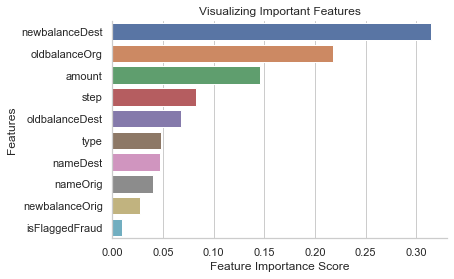

In [49]:
# Creating a bar plot
sns.set()
sns.set_style("whitegrid")
sns.barplot(x = feature_imp, y = feature_imp.index)
sns.despine()

# Adding labels to graph
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

### Which model worked better and how do you know?

In [51]:
# Your response here
"""
I'm highly suspicious of both scores. That said:

«Precision is a good measure to select the "best" model, when the costs of False Positive is
high. 

(...)

Recall shall be the model metric we use to select our best model when there is a high cost 
associated with False Negative.

For instance, in fraud detection or sick patient detection. If a fraudulent transaction 
(Actual Positive) is predicted as non-fraudulent (Predicted Negative), the consequence can 
be very bad for the bank.

(...)

F1 Score might be a better measure to use if we need to seek a balance between Precision and 
Recall AND there is an uneven class distribution (large number of Actual Negatives).

(...)

If you cannot decide or thinks that its best to reduce both, False Negatives and False 
Positives then choose F1.»

As such, judging from this, Recall or F1 seem to be the better measures to choose a model 
(and not accuracy or precision).

Source:
https://koopingshung.com/blog/machine-learning-model-selection-accuracy-precision-recall-f1/
"""

'\nI\'m highly suspicious of both scores. That said:\n\n«Precision is a good measure to select the "best" model, when the costs of False Positive is\nhigh. \n\n(...)\n\nRecall shall be the model metric we use to select our best model when there is a high cost \nassociated with False Negative.\n\nFor instance, in fraud detection or sick patient detection. If a fraudulent transaction \n(Actual Positive) is predicted as non-fraudulent (Predicted Negative), the consequence can \nbe very bad for the bank.\n\n(...)\n\nF1 Score might be a better measure to use if we need to seek a balance between Precision and \nRecall AND there is an uneven class distribution (large number of Actual Negatives).\n\n(...)\n\nIf you cannot decide or thinks that its best to reduce both, False Negatives and False \nPositives then choose F1.»\n\nAs such, judging from this, Recall or F1 seem to be the better measures to choose a model \n(and not accuracy or precision).\n\nSource:\nhttps://koopingshung.com/blog/mach

### Note: before doing the first commit, make sure you don't include the large csv file, either by adding it to .gitignore, or by deleting it.